Bisher gab es immer Probleme in der Exploration des Suchraumes, deswegen Vortrainierung des Netzes

In [1]:
import os
import sys
import ast
import pickle
import sqlite3

glp = os.path.abspath("../code")
if not glp in sys.path: sys.path.append( glp )

from global_paths import global_paths
if not global_paths["COBS"] in sys.path: sys.path.append( global_paths["COBS"] )

In [27]:
from DefaultBuildings import Building_5ZoneAirCooled_SingleAgent, Building_5ZoneAirCooled
from Agents import agent_constructor
import StateUtilities as SU
import RLCritics

import cobs

In [3]:
import numpy as np
import pandas as pd
import torch

from types import SimpleNamespace

In [34]:
args = SimpleNamespace(use_cuda = torch.cuda.is_available(),
        lr       = 0.001,
        ou_theta = 0.3,
        ou_mu    = 0.0,
        ou_sigma = 0.3,
        agent_w_l2     = 0.00005,
        critic_w_l2     = 0.00005,
        critic_hidden_size = 30,
        critic_hidden_activation = "LeakyReLU")

In [5]:
cobs.Model.set_energyplus_folder(global_paths["eplus"])
building = Building_5ZoneAirCooled()

In [6]:
# Define the agents
agents = []
for agent_name, (controlled_device, controlled_device_type) in building.agent_device_pairing.items():
    new_agent = agent_constructor( controlled_device_type )
    new_agent.initialize(name = agent_name,
                         controlled_element = controlled_device,
                         global_state_keys  = building.global_state_variables,
                         args = args)
    agents.append(new_agent)

In [7]:
# Nun ein ganzes Jahr einmal ablaufen
#   1. bei jedem Zeitschritt den Zustand speichern
#   2. und die zugehörige regelbasierte Aktion

In [8]:
f = open("../checkpoints/b001/complete_outputs.pickle", "rb")
episode_states_list, episode_actions_list, episode_cobs_send_list = pickle.load(f)
f.close()

In [9]:
# Danach die Agenten damit trainieren (immer wieder batches herausnehmen)
# Zuletzt die Agenten speichern

In [10]:
normed_states_list = []
for state in episode_states_list:
    normed_states_list.append( SU.unnormalized_state_to_tensor(state, building) )

normed_states = torch.cat(normed_states_list)

In [11]:
agent_target_output = { agent_name: [] for agent_name in building.agent_device_pairing.keys() }
for actions_dict in episode_actions_list:
    for agent in agents:
        normed_dict = SU.normalize_variables_in_dict(actions_dict[agent.name])
        output_ten  = agent.action_dict_to_output_tensor( normed_dict )
        agent_target_output[agent.name].append( output_ten )

for agent_name in building.agent_device_pairing.keys():
    agent_target_output[agent_name] = torch.cat( agent_target_output[agent_name] )

In [12]:
num_elems  = len(episode_states_list)
batch_size = 128
n_trainruns= 4000

In [13]:
#loss = torch.nn.MSELoss()
loss = torch.nn.L1Loss()
loss_list = {agent.name: [] for agent in agents}

In [14]:
for i in range(n_trainruns):
    batch_idx = np.random.randint(0, num_elems, batch_size)
    batch_states  = normed_states [ batch_idx ]

    for agent in agents:
        agent.model_actor.zero_grad()
        y_ist = agent.step_tensor(batch_states)
        y_soll= agent_target_output[agent.name][ batch_idx ].detach()
        L     = loss(y_ist, y_soll)
        L.backward()
        agent.optimizer_step()
        loss_list[agent.name].append(float(L.detach().numpy()))

    if i % 20 == 0:
        print(f"Run {i} finished")

Run 0 finished
Run 20 finished
Run 40 finished
Run 60 finished
Run 80 finished
Run 100 finished
Run 120 finished
Run 140 finished
Run 160 finished
Run 180 finished
Run 200 finished
Run 220 finished
Run 240 finished
Run 260 finished
Run 280 finished
Run 300 finished
Run 320 finished
Run 340 finished
Run 360 finished
Run 380 finished
Run 400 finished
Run 420 finished
Run 440 finished
Run 460 finished
Run 480 finished
Run 500 finished
Run 520 finished
Run 540 finished
Run 560 finished
Run 580 finished
Run 600 finished
Run 620 finished
Run 640 finished
Run 660 finished
Run 680 finished
Run 700 finished
Run 720 finished
Run 740 finished
Run 760 finished
Run 780 finished
Run 800 finished
Run 820 finished
Run 840 finished
Run 860 finished
Run 880 finished
Run 900 finished
Run 920 finished
Run 940 finished
Run 960 finished
Run 980 finished
Run 1000 finished
Run 1020 finished
Run 1040 finished
Run 1060 finished
Run 1080 finished
Run 1100 finished
Run 1120 finished
Run 1140 finished
Run 1160 fin

In [15]:
loss_df = {agent.name: np.array(loss_list[agent.name]) for agent in agents}

<AxesSubplot:>

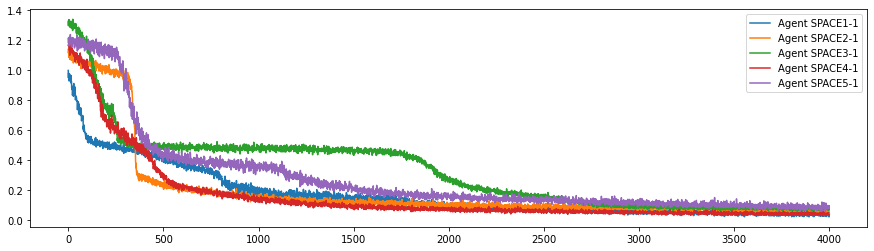

In [16]:
pd.DataFrame(loss_df).plot(figsize=(15,4))

In [17]:
agent5   = agents[0]
y_target = agent_target_output[ agent5.name ]

outputs = []
for st in normed_states_list:
    y = agent5.step_tensor(st)
    y_dict = agent5.output_tensor_to_action_dict(y)
    outputs.append( SU.backtransform_variables_in_dict(y_dict) )

outputs_target = []
for row in y_target:
    y_dict = agent5.output_tensor_to_action_dict( row )
    outputs_target.append( SU.backtransform_variables_in_dict(y_dict) )

In [18]:
df_target = pd.DataFrame(outputs_target)
df_ist    = pd.DataFrame(outputs)

df_target.columns = [ f"Target {colname}" for colname in df_target.columns ]

In [19]:
df = pd.concat([df_ist, df_target], axis=1)

<AxesSubplot:>

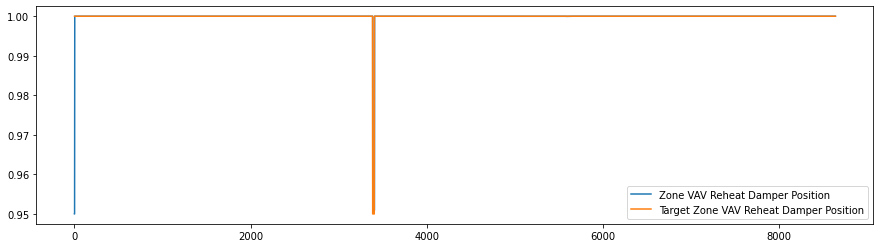

In [20]:
df.loc[:, ["Zone VAV Reheat Damper Position", "Target Zone VAV Reheat Damper Position"]].plot(figsize=(15,4))

<AxesSubplot:>

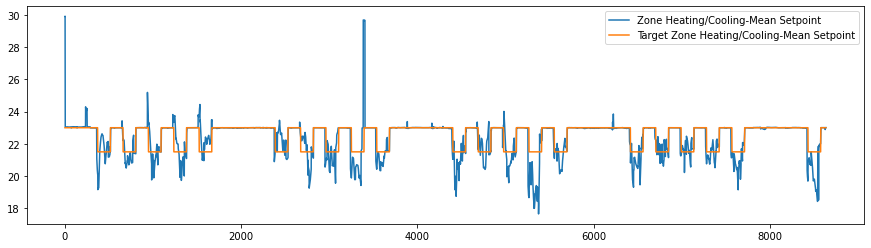

In [21]:
df.loc[:, ["Zone Heating/Cooling-Mean Setpoint", "Target Zone Heating/Cooling-Mean Setpoint"]].plot(figsize=(15,4))

<AxesSubplot:>

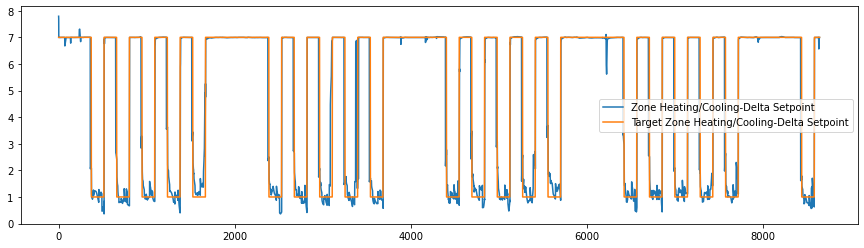

In [22]:
df.loc[:, ["Zone Heating/Cooling-Delta Setpoint", "Target Zone Heating/Cooling-Delta Setpoint"]].plot(figsize=(15,4))

In [23]:
# copy weights to target network
for agent in agents:
    for mactor_param, mtarget_param in zip(agent.model_actor.parameters(), agent.model_target.parameters()):
        mtarget_param.data.copy_(mactor_param.data)

In [42]:
# Save the models
path1 = "../checkpoints/s020/pretrained"
os.makedirs(path1, exist_ok=True)
for idx, agent in enumerate(agents):
    agent.save_models_to_disk(path1, prefix=f"episode_10_agent_{idx}")

In [35]:
# randomly initialize the critics and save them 
critics = []
ciritic_input_variables=["Minutes of Day","Day of Week","Calendar Week",
                         "Outdoor Air Temperature","Outdoor Air Humidity",
                         "Outdoor Wind Speed","Outdoor Wind Direction",
                         "Outdoor Solar Radi Diffuse","Outdoor Solar Radi Direct"]
for vartype in ["Zone Temperature","Zone People Count",
                "Zone Relative Humidity",
                "Zone VAV Reheat Damper Position","Zone CO2"]:
    ciritic_input_variables.extend( [f"SPACE{k}-1 {vartype}" for k in range(1,6)] )
for agent in agents:
    new_critic = RLCritics.CriticMergeAndOnlyFC(
                    args = args,
                    input_variables=ciritic_input_variables,
                    agents = agents,
                    global_state_keys=building.global_state_variables)
    critics.append(new_critic)

In [43]:
# save the critics
os.makedirs(path1, exist_ok=True)
for idx, critic in enumerate(critics):
    critic.save_models_to_disk(path1, prefix=f"episode_10_critic_{idx}")